## Import Libraries

In [4]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [5]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [6]:
df.shape

(5624, 11)

In [7]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [8]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [9]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [10]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [11]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [12]:
for i in categorical_features:
    print (df[i].value_counts())

Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: Type, Length: 347, dtype: int64
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: Region, dtype: int64
Toyota          1430
Hyundai          668
Ford             530
Chevrolet        458
Nissan    

In [13]:
df = df[df['Year']>=2000]

In [14]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [15]:
df.shape

(5364, 11)

In [16]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [17]:
df.shape

(5364, 11)

In [18]:
#df[df['Type']=='Other']

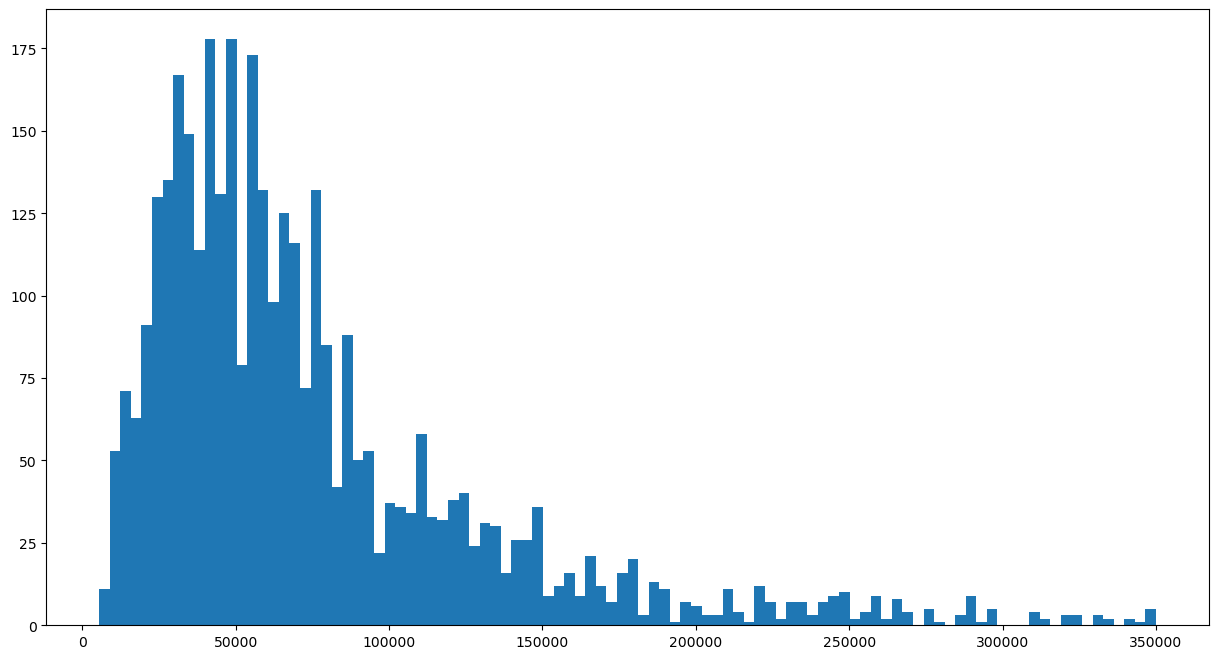

In [19]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [20]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [21]:
df.shape

(3566, 11)

In [22]:
#df[df['Mileage']<1000]

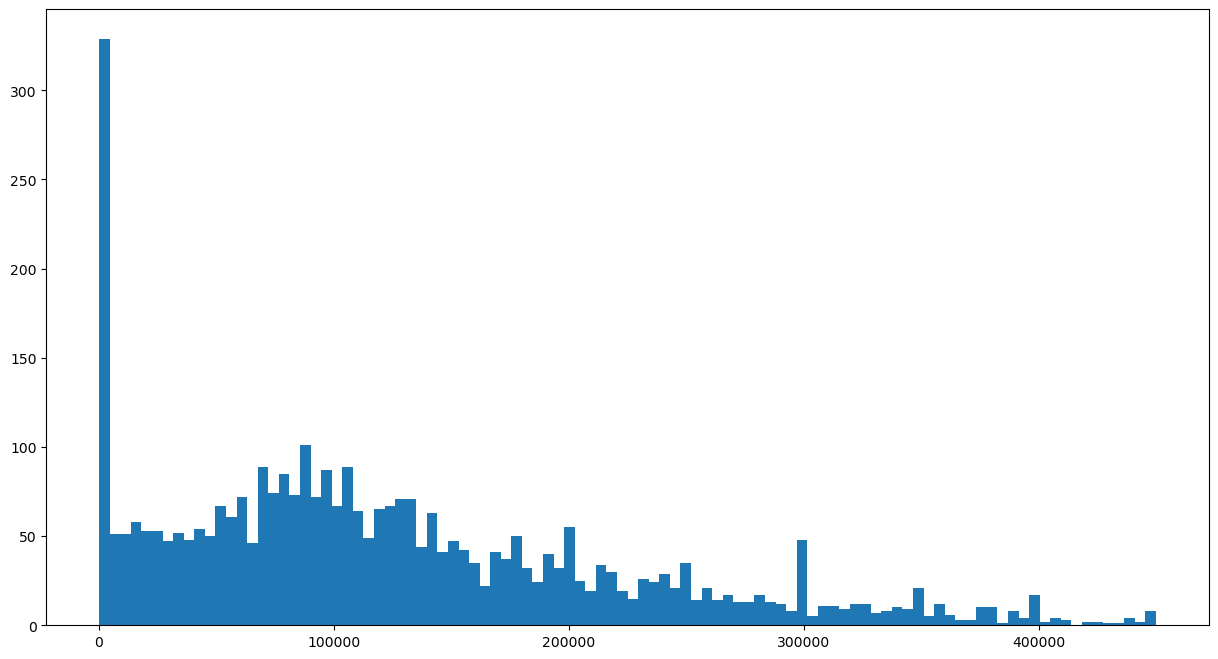

In [23]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [24]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [25]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [26]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [27]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [28]:
df.shape

(3511, 325)

In [29]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,2015,5.0,140000,False,260000,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [30]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['Price'].quantile(0.35)
p75 = df['Price'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['car_price_category'] = df['Price'].apply(categorize_price)

df.drop('Price', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['car_price_category'].value_counts())

Good_Price     1404
Cheap_Price    1227
High_Price      880
Name: car_price_category, dtype: int64


In [31]:
p35, p75

(46000.0, 95000.0)

In [32]:
#df['car_price_category'] 

In [33]:
encoder = LabelEncoder()
df['car_price_category_encoded'] = encoder.fit_transform(df['car_price_category'])  

#### 3. Feature selection

In [34]:
# sns.heatmap(df.corr(), annot=True);

In [38]:
correlation = df.corr()
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['car_price_category_encoded'].sort_values(ascending=False))

car_price_category_encoded    1.000000
Year                          0.407525
Engine_Size                   0.334464
Options_Full                  0.305622
Make_Mercedes                 0.225376
                                ...   
Make_Hyundai                 -0.223059
Type_Accent                  -0.237844
Options_Standard             -0.283697
Mileage                      -0.287567
Negotiable                         NaN
Name: car_price_category_encoded, Length: 325, dtype: float64


In [39]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['car_price_category_encoded']) > \
threshold]['car_price_category_encoded'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
       'car_price_category_encoded'],
      dtype='object')

In [40]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
                      'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
                      'car_price_category_encoded']

In [41]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Type_Accent,Type_Land Cruiser,Make_Hyundai,Make_Mercedes,Options_Full,Options_Standard,car_price_category_encoded
1,2014,8.0,80000,0,0,0,0,1,0,2
2,2015,5.0,140000,0,0,0,0,1,0,2
3,2015,2.4,220000,0,0,0,0,0,0,0
5,2019,2.0,25000,0,0,0,0,0,0,1
6,2012,4.8,189000,0,0,0,0,1,0,1


#### 4. Prepare train and test data

In [42]:
# Prepare data
X = df.drop(['car_price_category_encoded'], axis=1)
y = df['car_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# np.array([list(dict_f.values())])

In [45]:
X.iloc[0,:].values

array([2.014e+03, 8.000e+00, 8.000e+04, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00])

In [46]:
from fastapi.encoders import jsonable_encoder
json_compatible_data = jsonable_encoder(dict_f)

In [47]:
json_compatible_data

In [48]:
dict_f = {'Year': 1,
              'Engine_Size': 3, 
              'Mileage':444, 
              'Type_Accent': True ,
              'Type_Land Cruiser': False,
              'Make_Hyundai': True ,
              'Make_Mercedes': True ,
              'Options_Full': True ,
              'Options_Standard': True 
             }
scaler.transform(np.array([list(dict_f.values())]))

array([[-5.23473954e+02, -1.21352243e-01, -1.26063244e+00,
         4.86123225e+00, -1.94149461e-01,  2.57094459e+00,
         4.88360088e+00,  1.30284548e+00,  1.34670979e+00]])

In [49]:
X.shape

(3511, 9)

In [50]:
X.head(2)

,Year,Engine_Size,Mileage,Type_Accent,Type_Land Cruiser,Make_Hyundai,Make_Mercedes,Options_Full,Options_Standard
1,2014,8.0,80000,0,0,0,0,1,0
2,2015,5.0,140000,0,0,0,0,1,0


## Buliding the Model

In [51]:
model = KNeighborsClassifier()

In [52]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [53]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [54]:
grid_search.best_params_

{'n_neighbors': 5}

In [55]:
model = grid_search.best_estimator_

## Test the Model

In [56]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [57]:
# our benchmark model
base_model = round(df['car_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

39.99

1. Accuracy

In [58]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7411095305832148

In [59]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8141025641025641

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[186,  52,   5],
       [ 55, 192,  33],
       [  4,  33, 143]])

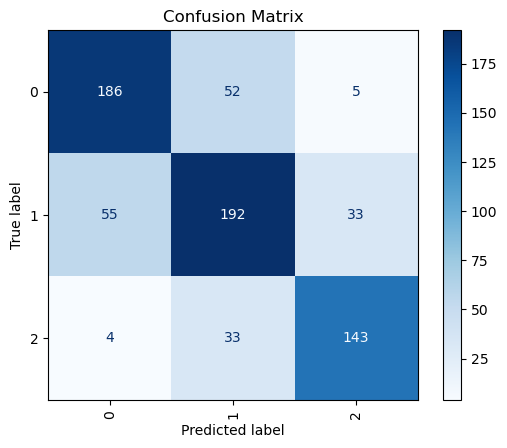

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.75


In [63]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.75


In [64]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.75


In [65]:
# from sklearn.inspection import DecisionBoundaryDisplay
 
# # Plot Decision Boundary
# DecisionBoundaryDisplay.from_estimator(
#         model,
#         X_train,
#         response_method="predict",
#         cmap=plt.cm.Spectral,
#         alpha=0.8,
#     )
 
# # Scatter plot
# plt.scatter(X[:, 0], X[:, 1], 
#             c=y, 
#             s=20, edgecolors="k")
# plt.show()

In [68]:
import joblib
joblib.dump(model, 'Model/knn_model.joblib')
joblib.dump(scaler, 'Model/scaler.joblib')

['scaler.joblib']